# **Predictive Crime Mapping with a spatio-temporal kernel density estimation approach**

## **Case of study: Dallas City**

*Institute of Mathematical and Computational Engineering*

*School of Engineering*

*Pontifical Catholic University of Chile*

**Authors:** Christian Carstens, Mauro Mendoza, Francisco Tobar

**Date:** 2019-04-11

`Python version: 3.7`

### **DB Request**

In [13]:
import pandas as pd
from sodapy import Socrata

import credentials as cre

In [59]:
with Socrata(cre.socrata_domain,
             cre.API_KEY_S,
             username=cre.USERNAME_S,
             password=cre.PASSWORD_S) as client:
    query = """
select
    incidentnum,
    geocoded_column,
    date1,
    time1,
    x_coordinate,
    y_cordinate
where
    geocoded_column is not null
    and date1 is not null
    and time1 is not null
    and x_coordinate is not null
    and y_cordinate is not null
limit
    3000
""" # 530000 max. 11/04

    results = client.get(cre.socrata_dataset_identifier, query=query, content_type='json')
    df = pd.DataFrame.from_records(results)

### **DB Cleaning & Formatting**

In [60]:
df.loc[:, 'x_coordinate'] = df['x_coordinate'].apply(lambda x: float(x))
df.loc[:, 'y_cordinate'] = df['y_cordinate'].apply(lambda x: float(x))

df = df[['x_coordinate', 'y_cordinate']]

df.rename(columns={'x_coordinate':'x', 'y_cordinate':'y'}, inplace=True)

In [61]:
df.head()

,x,y
0,2.484649e+06,6.922683e+06
1,2.503765e+06,6.963129e+06
2,2.498941e+06,6.980448e+06
3,2.522040e+06,6.983396e+06
4,2.525626e+06,6.964722e+06


### Plotting

In [ ]:
import pandas as pd

import numpy as np

%matplotlib inline
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats import kde
import scipy.stats as st

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

from sklearn.datasets.samples_generator import make_blobs

In [ ]:
dallas = gpd.read_file('shp/STREETS.shp')
crs = dallas.crs
# crs

In [ ]:
fig, ax = plt.subplots(figsize = (15, 15))
ax.set_facecolor('xkcd:black')

dallas.plot(ax = ax, alpha = .4, color="gray")

In [ ]:
geometry = [Point(xy) for xy in zip(df['x'], df['y'])]
geo_df = gpd.GeoDataFrame(df,
                         crs = crs,
                         geometry = geometry)

fig, ax = plt.subplots(figsize = (15, 15))
ax.set_facecolor('xkcd:black')

dallas.plot(ax = ax, alpha = .4, color="gray")
geo_df.plot(ax = ax, markersize = 10, color = 'red', marker = 'o', label = 'Incident')
plt.legend(prop={'size': 15})

nbins = 200
data = np.array(df[['x','y']])

x, y = data.T

k = kde.gaussian_kde(data.T)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cs = plt.contour(xi, yi, zi.reshape(xi.shape), cmap = 'jet')

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=cs.cvalues.min(), vmax=cs.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap = cs.cmap)
sm.set_array([])
fig.colorbar(sm, ticks=cs.levels, shrink=.4, aspect=10)

# plt.savefig('figura.png')

In [ ]:
fig, ax = plt.subplots(figsize = (15, 15))
ax.set_facecolor('xkcd:black')

dallas.plot(ax = ax, alpha = .4, color="gray")
geo_df.plot(ax = ax, markersize = 10, color = 'red', marker = 'o', label = 'Incident')
plt.legend(prop={'size': 15})

nbins = 100
data = np.array(df[['x','y']])

k = kde.gaussian_kde(data.T)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
# cs = plt.contour(xi, yi, zi.reshape(xi.shape), cmap = 'jet')

plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap='jet')
# plt.contour(xi, yi, zi.reshape(xi.shape))
plt.show()

FigureCanvasNbAgg()

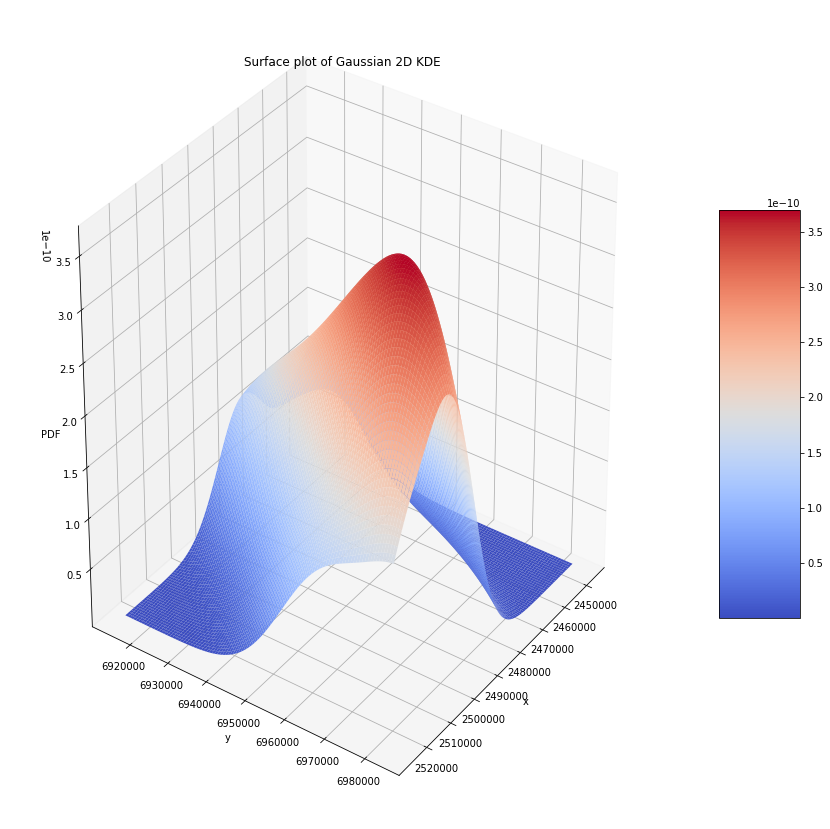

In [49]:
from mpl_toolkits import mplot3d
%matplotlib widget

fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xi, yi,  zi.reshape(xi.shape), rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(30, 35)